# Bricks and Board Code Challenge

## The Problem

I am in an open field with an endless supply of bricks. My hobby is stacking bricks up in equally-spaced columns of random heights.

I choose the number of columns randomly. It could be 10, or 27, or 63,972,152. I'm a patient guy and I like columns of bricks.

Each time, when I'm done, I lay a wooden board on top of the columns of bricks. I have access to a huge variety of board lengths, so I always choose one that starts exactly above the top of the first column, and stretches to exactly above the top of the last column, regardless of its angle.

It doesn't always touch the tops of those columns, of course. I chose the column heights randomly. Maybe on some occasions it rests on those, but in other cases it comes to rest on bricks anywhere in between them. It all depends on the height of the columns and where gravity dictates the board will sit. But in any case, these bricks are rough enough that the board never slides off, even at severe slopes.

Your job is to figure out, given the number of bricks in each column, the slope and y-intercept of my board.

Columns of bricks are provided in an array, where the array index is "x" and the value is "y".

## Forget The High School Line Formula Stuff?

Me too. Here's a quick refresher:

A straight line is defined by the formula y = mx + b:

* **x:** the column number, starting from 0
* **y:** the height of the board, in bricks, at that column
* **m:** the slope of the board, or "rise over run": take two points the board is touching, x1,y1 and x2,y2, and the slope is (y2 - y1) / (x2 - x1).
* **b:** y-intercept: how high the board is from the ground, in bricks, at column 0

> _Important Note:_ For simplicity, let's ignore the fact that any angled board will have a slightly varying height over the width of a stack of bricks. The board's height (y) when it's touching a brick is equal to the number of bricks beneath it.

## Here's an example

`[2, 14, 8, 94, 300, 210, 200, 99, 14, 12]`

Laying a board on top of this, it comes to rest on x=4 y=300, and x=6 y=200. ("Not 300 and 210?!" Some of you are thinking? Nope, if it rested on 210, the slope would be too severe that it would fall BELOW the top of the 200 stack. For real, check the math. This problem isn't as simple as it sounds.)

Slope is rise `(y2 - y1)` divided by run `(x2 - x1)`. So: `(200 - 300) / (6 - 4) = -50`.

y-intercept can then be found by plugging the slope into the y=mx+b line equation for either of those resting points above. I'll pick x=6 y=200:

```
200 = -50 * 6 + b
200 = -300 + b
b = 200 - -300
b = 500
```

So with those stacks, slope is **-50** and y-intercept is **500**.

Write me a function that outputs those two variables given any input array. No gravity-defying boards!

## We'll start with some boilerplate code to generate data and charts

No need to edit this, but we'll use it later.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import json

# Function to generate an array of random integers
def generate_random_array(data_length):
    return np.random.randint(0, 100, data_length)

# Function to plot the data and the line
def plot_data_with_line(arr, slope, y_intercept, cursors=None):
    x = np.arange(len(arr))
    y = arr
    
    plt.scatter(x, y, color='red', label='Brick Column Tops')
    plt.plot(x, slope * x + y_intercept, color='blue', label='Board')

    if cursors is not None:
        plt.axvline(x=cursors[0], color='green', linestyle='--', label='Cursor L')
        plt.text(cursors[0], plt.ylim()[0], 'Low', color='green', verticalalignment='bottom', horizontalalignment='right')
        plt.axvline(x=cursors[1], color='green', linestyle='--', label='Cursor H')
        plt.text(cursors[1], plt.ylim()[0], 'High', color='green', verticalalignment='bottom', horizontalalignment='right')
    
    plt.xlabel('Brick Column')
    plt.ylabel('Brick Height')
    plt.title('Brick Tops and Board')
    plt.show()

## Now it's your turn!

There's a code block below where you'll click and write your solution in Python. Not familiar with Python? No problem! Click CodeWhisperer -> Start CodeWhisperer:

![Start CodeWhiperer](http://i.tomfro.st/7Epnpy.png)

You can create a free Amazon Q sign-in if you don't have one. Click again, and you can see the shortcuts. I recommend clicking "Resume Auto-Suggestions":

![Resume Auto-Suggestions](http://i.tomfro.st/ZziCkh.png)

## Write your code here! The starter code runs, but isn't a real solution.

In [54]:
import math

# This solution takes a completely different approach from Tom_Simple
# and Tom_Advanced. It finds the solution by considering only the slope of
# the line, and calculates the y-intercept only for the purpose of the
# return value. Here are the steps:
#
# 1. Understanding that there could be more than one brick column with the
#    maximum number of bricks, find the maximum closest to the board's middle.
# 2. The half of the board with this max is the high side of the board, and
#    the board will definitely slope down to the other half. Call this point
#    the "high touch", and call the highest value from the other side of the
#    board the "low touch".
# 3. Loop through all points between the low touch point and the low end of the
#    line (away from the midpoint). For each point, calculate the slope between
#    it and the high touch. If the resulting slope is closer to 0 than the
#    current line between the high and low touch points, then update this point
#    to be the low touch point.
# 4. Loop through all points between the high touch point and the midpoint.
#    Like step 3, we calculate the slope between that point and the low touch,
#    but this time we're looking for steeper slopes, farther from 0. When a
#    steeper slope is found, this becomes the new high touch.
# 5. If we changed the high touch in the last step, go to step 3.
# 6. The touchpoints and slope are now accurate. Calculate y-intercept and return.
#
# Performance:
# This is an *extremely* fast O(n) solution that requires one full scan through
# every point, and, on average, one half scan.
#
# But this is still 2-3x the execution time of Darren's solution that requires
# 3 scans. Why? Darren's first two scans both require far simpler logic than this
# solution's full scan. That simple logic can be represented in a Python lambda and
# passed to numpy, allowing those scans to be carried out in numpy's native compiled
# machine code rather than the Python interpreter, which is so fast that those scans
# barely impact execution time. It's a very slick performance bump!
def calculate_slope_intercept(arr, debug=False):
    if len(arr) < 2:
        raise ValueError("Array must have at least two elements")

    # Get the highest column(s), the closest max to the middle, and the max
    # point of each side of the midpoint.
    #
    # The closest max to middle is the "high touch": The line's touchpoint
    # on the upslope half. This point may change later.
    mid = (len(arr) - 1) / 2
    max_height = 0
    max_cols = []
    high_touch_mid_dist = len(arr)
    high_touch_xy = 0, 0
    lmax_xy = 0, 0
    rmax_xy = 0, 0
    for x, y in enumerate(arr):
        if y > max_height:
            max_cols = []
            high_touch_mid_dist = len(arr)
            max_height = y
        if y == max_height:
            max_cols.append(x)
            dist = abs(mid - x)
            if dist < high_touch_mid_dist:
                high_touch_xy = x, y
                high_touch_mid_dist = dist
        if x < mid:
            if lmax_xy[1] < y:
                lmax_xy = x, y
        elif rmax_xy[1] <= y:
            rmax_xy = x, y

    # Short circuit: Is it on the midpoint only, or on each side of the midpoint? flat line
    if max_cols[0] <= mid <= max_cols[-1]:
        return 0, max_height

    # The side of the line with the high touch determines the slope direction.
    # Choose the max of the opposite side from the high touch as the "low" touch
    # point. Set up values to scan from the low touch to the line end
    if high_touch_xy[0] < mid:
        low_touch_xy = rmax_xy
        low_start = low_touch_xy[0] + 1
        low_end = len(arr)
        high_start = high_touch_xy[0] + 1
        high_end = math.ceil(mid)
        step = 1
    else:
        low_touch_xy = lmax_xy
        low_start = low_touch_xy[0] - 1
        low_end = -1
        high_start = high_touch_xy[0] - 1
        high_end = math.floor(mid)
        step = -1

    def get_new_slope(pt1, pt2):
        return (pt1[1] - pt2[1]) / (pt1[0] - pt2[0])

    # We scan the half of the data under the downslope first, looking for the
    # point that produces the minimum possible slope to the high touch point
    slope = get_new_slope(high_touch_xy, low_touch_xy)
    slope_abs = abs(slope)

    if debug:
        y_intercept = low_touch_xy[1] - slope * low_touch_xy[0]
        plot_data_with_line(arr, slope, y_intercept, [low_touch_xy[0], high_touch_xy[0]])

    changed = True
    while changed:
        changed = False
        for x in range(low_start, low_end, step):
            pt = (x, arr[x])
            new_slope = get_new_slope(high_touch_xy, pt)
            if abs(new_slope) < slope_abs and (new_slope >= 0) == (slope >= 0):
                low_touch_xy = pt
                slope = new_slope
                slope_abs = abs(slope)
                if debug:
                    y_intercept = low_touch_xy[1] - slope * low_touch_xy[0]
                    plot_data_with_line(arr, slope, y_intercept, [low_touch_xy[0], high_touch_xy[0]])
    
        # The low touch is now set. Scan for a better high touch by moving from
        # the current high touch x to the mid, looking for a greater slope.
        # If we change the line, we'll need to loop these steps again to see if there's a
        # better low-touch given the new slope.
        for x in range(high_start, high_end, step):
            pt = (x, arr[x])
            new_slope = get_new_slope(low_touch_xy, pt)
            if abs(new_slope) > slope_abs and (new_slope >= 0) == (slope >= 0):
                high_touch_xy = pt
                slope = new_slope
                slope_abs = abs(slope)
                changed = True
                if debug:
                    y_intercept = low_touch_xy[1] - slope * low_touch_xy[0]
                    plot_data_with_line(arr, slope, y_intercept, [low_touch_xy[0], high_touch_xy[0]])

    # Done. Find the intercept and leave
    y_intercept = high_touch_xy[1] - slope * high_touch_xy[0]
    return slope, y_intercept
    

## Run it and see how it does!

The first time you run this code, hit the "Run all cells" button to initialize the boilerplate code:

![Run All Cells](http://i.tomfro.st/adTxxK.png)

After that, you can just click into the code block below and press the play button to see your code run on new random data:

![Play Button](http://i.tomfro.st/Y5dYGc.png)

If you change your code, remember that you'll need to re-run that cell or use the "Run all cells" button again!

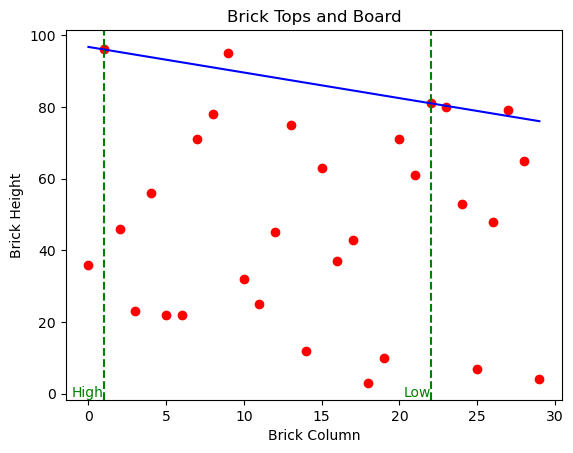

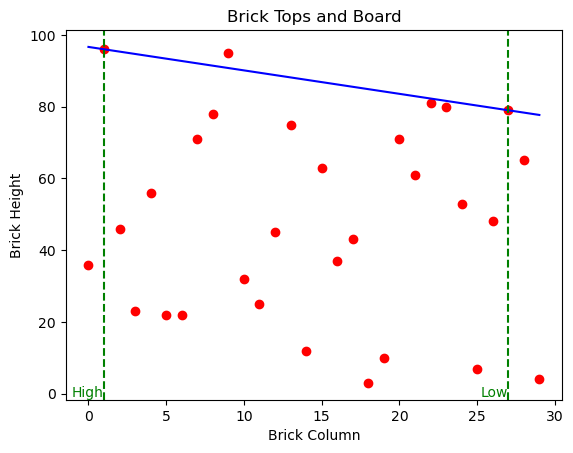

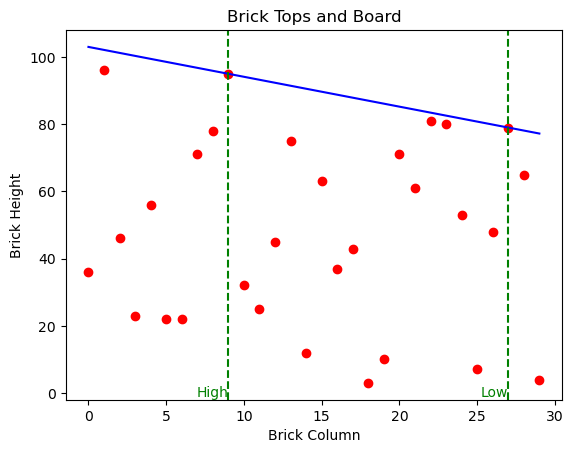

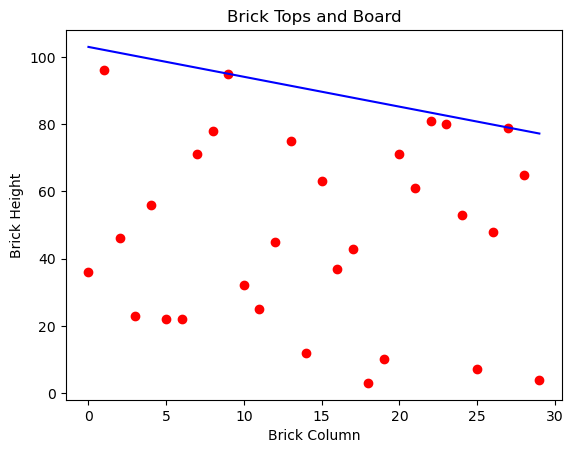

Data: [36, 96, 46, 23, 56, 22, 22, 71, 78, 95, 32, 25, 45, 75, 12, 63, 37, 43, 3, 10, 71, 61, 81, 80, 53, 7, 48, 79, 65, 4]
Slope: -0.8888888888888888
Y-Intercept: 103.0


In [55]:
# Calling the functions to visualize the output
data_length = 30
random_array = np.array([36, 96, 46, 23, 56, 22, 22, 71, 78, 95, 32, 25, 45, 75, 12, 63, 37, 43, 3, 10, 71, 61, 81, 80, 53, 7, 48, 79, 65, 4])
#random_array = generate_random_array(data_length)
slope, y_intercept = calculate_slope_intercept(random_array, True)
plot_data_with_line(random_array, slope, y_intercept)
print("Data:", json.dumps(random_array.tolist()))
print("Slope:", slope)
print("Y-Intercept:", y_intercept)

## Test it

Run the following code block to test your solution's accuracy. We'll run it 1000 times and check to make sure all the dots are on or under the line, and the line isn't defying gravity.

In [56]:
def print_fail(num, arr, slope, y_intercept, err):
    print(f"Test {num + 1} failed!")
    print(err)
    plot_data_with_line(arr, slope, y_intercept)
    print("Data:", json.dumps(arr.tolist()))
    print("Slope:", slope)
    print("Y-Intercept:", y_intercept)

errored = False
error_margin = 0.0000000000001
for i in range(0, 1000):
    arr = generate_random_array(30)
    slope, y_intercept = calculate_slope_intercept(arr)
    left_touch = False
    right_touch = False
    # Make sure all the points in arr are on or beneath the line
    for x, y in enumerate(arr):
        if y > slope * x + y_intercept + error_margin:
            print_fail(i, arr, slope, y_intercept, f"Point ({x},{y}) is above the line")
            errored = True
            break
        # Set touch to True if we find a point on the line
        if y > slope * x + y_intercept - error_margin:
            if x < len(arr) / 2:
                left_touch = True
            else:
                right_touch = True
    if not errored and not (left_touch and right_touch):
        print_fail(i, arr, slope, y_intercept, "The board is defying gravity!")
        errored = True
    if errored: break

if not errored: print("All tests passed!")

All tests passed!


Text(0, 0.5, 'Time Taken')

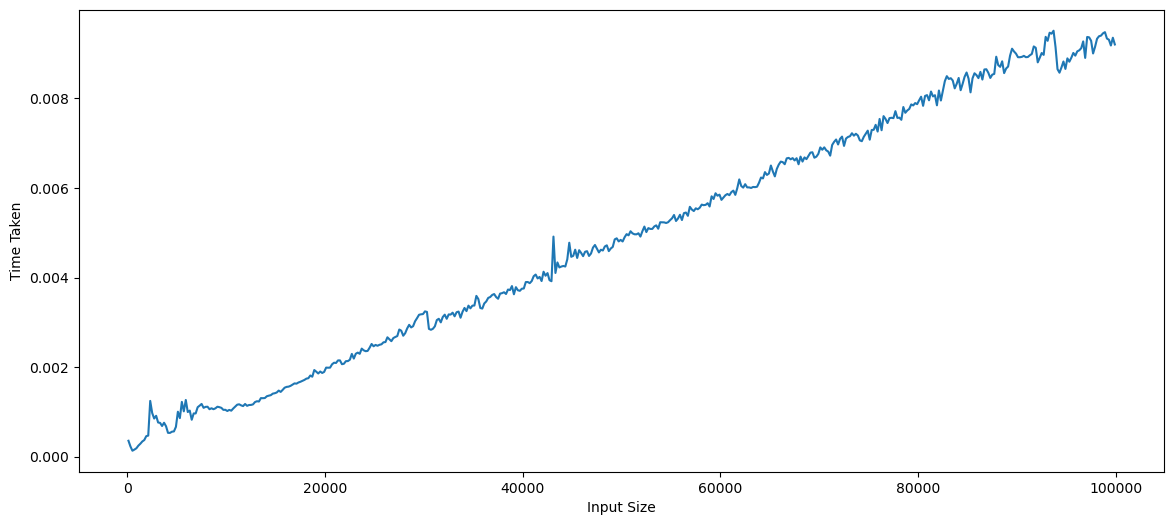

In [57]:
import time

input_sizes = range(100, 100000, 200)
samples = 2
times = []
for n in input_sizes:
    total = 0
    for j in range(samples):
        start_time = time.time()
        random_array = generate_random_array(n)
        slope, y_intercept = calculate_slope_intercept(random_array)
        end_time = time.time()
        total += (end_time - start_time)
    times.append(total / samples)

plt.figure(figsize=(14, 6))
plt.plot(input_sizes, times)
plt.xlabel('Input Size')
plt.ylabel('Time Taken')